# Grad-CAM for Fluid Flow regression probelem (Drag coefficient prediction)

### Author: M. Morimoto (Keio University, Japan)

Masaki Morimoto provides no guarantees for this code. Use as-is and for academic research use only; no commercial use allowed without permission. For citations, please use the reference below:

Ref: Masaki Morimoto, Kai Fukami, Kai Zhang, and Koji Fukagata, "Generalization techniques of neural networks for fluid flow estimation," arXiv:2011.11911 (2020).
The code is written for educational clarity and not for speed.


Despite the code is for scalar output, same code can be utilized for two-dimensional output data.

-- version 1: Feb 3, 2021

For performing Grad-CAM, the user has to install 'keras', 'numpy', 'pandas' and 'cv2'.

References

[1] Codes & problem setting

K. Fukami, K. Fukagata, and K. Taira, "Assessments of supervised machine learning for fluid flows," Theor. Comput. Fluid Dyn., 34(4), pp.497--519, 2020

[2] Cylinder DNS (immersed boundary method)

H. Kor, M. Badri Ghomizad, and K. Fukagata. "A unified interpolation stencil for ghost-cell immersed boundary methodfor flow around complex geometries," J. Fluid Sci. Technol., 12(1):JFST0011, 2017.

[3] Referenced link (Grad-CAM)

https://qiita.com/bele_m/items/a7bb15313e2a52d68865

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import cv2

from keras import backend as K
from keras.models import load_model

# Font setting
plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.rc('text', usetex=True)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Times New Roman')

Using TensorFlow backend.


## Data load

In [3]:
#-- configurations --#
num_dat = 20 # number of snapshot
nx = 384 # number of grids in x direction
ny = 192 # number of grids in y direction

#-- load coordinates --#
df = pd.read_csv('./Xcor',header=None,delim_whitespace=True)
dataset = df.values
xca = dataset[9:393,1]

df = pd.read_csv('./Ycor',header=None,delim_whitespace=True)
dataset = df.values
yca = dataset[4:196,1]

print(xca.shape)
print(yca.shape)

#-- data load --#
omega = np.zeros((num_dat,nx,ny,1))
for nt in tqdm(range(num_dat)):
    omega[nt,:,:,0] = np.loadtxt('./vorticity_field/omg_dat-'+'{0:02d}'.format(nt)+'.csv',delimiter=',')

cd = np.loadtxt('./cd_dat.csv',delimiter=',')

print(omega.shape)
print(cd.shape)

### Grad-CAM

In [6]:
#-- model load --#
filename = 'CD-prediction_forGradCAM_CNN-MLP_fkgtlab-cylinder'
model = load_model('/home/morimoto/Models/'+filename+'.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 384, 192, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 384, 192, 32)      832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 192, 96, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 192, 96, 32)       25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 96, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 48, 16)        12816     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 24, 16)        0         
__________

In [8]:
#-- define Grad-CAM function
def grad_cam(model, layer_name, input_data):
    
    '''
    This function requires
    1. model: which is already trained
    2. layer_name: Name of the target layer to calculate gradient
    3. input_data: Input data in size of the input of the model
    
    and returns visualization of feature intensity at the target layer
    '''
    convout_tensor = model.get_layer(layer_name).output  # output of the target convolution layer/Tensor

    grad_tensor = K.gradients(model.output, convout_tensor)[0] # gradient among convout_tensor and model.output/Tensor
    grad_func = K.function([model.input], [convout_tensor, grad_tensor]) # a function to calculate the gradient

    convout_val, grads_val = grad_func([input_data])
    convout_val, grads_val = convout_val[0], grads_val[0]

    weights = np.mean(grads_val, axis=(0,1))  # mean weights per each channel
    grad_cam = np.dot(convout_val, weights)  # output of the target layer is weighted
    grad_cam = np.maximum(grad_cam, 0) # ReLU
    grad_cam = cv2.resize(grad_cam, (ny, nx), cv2.INTER_LINEAR)  # Resize
    return grad_cam


#-- calculate Grad-CAM at each instanteneous snapshots --#
omega_inst = np.zeros((1,nx,ny,1)) # instanteneous snapshot of input vorticity field
grad_cam_map = np.zeros((num_dat,nx,ny))

for nt in tqdm(range(num_dat)):
    omega_inst[0,:,:,:] = omega[nt,:,:,:]
    grad_cam_map[nt,:,:] = grad_cam(model, "conv2d_10", omega_inst)

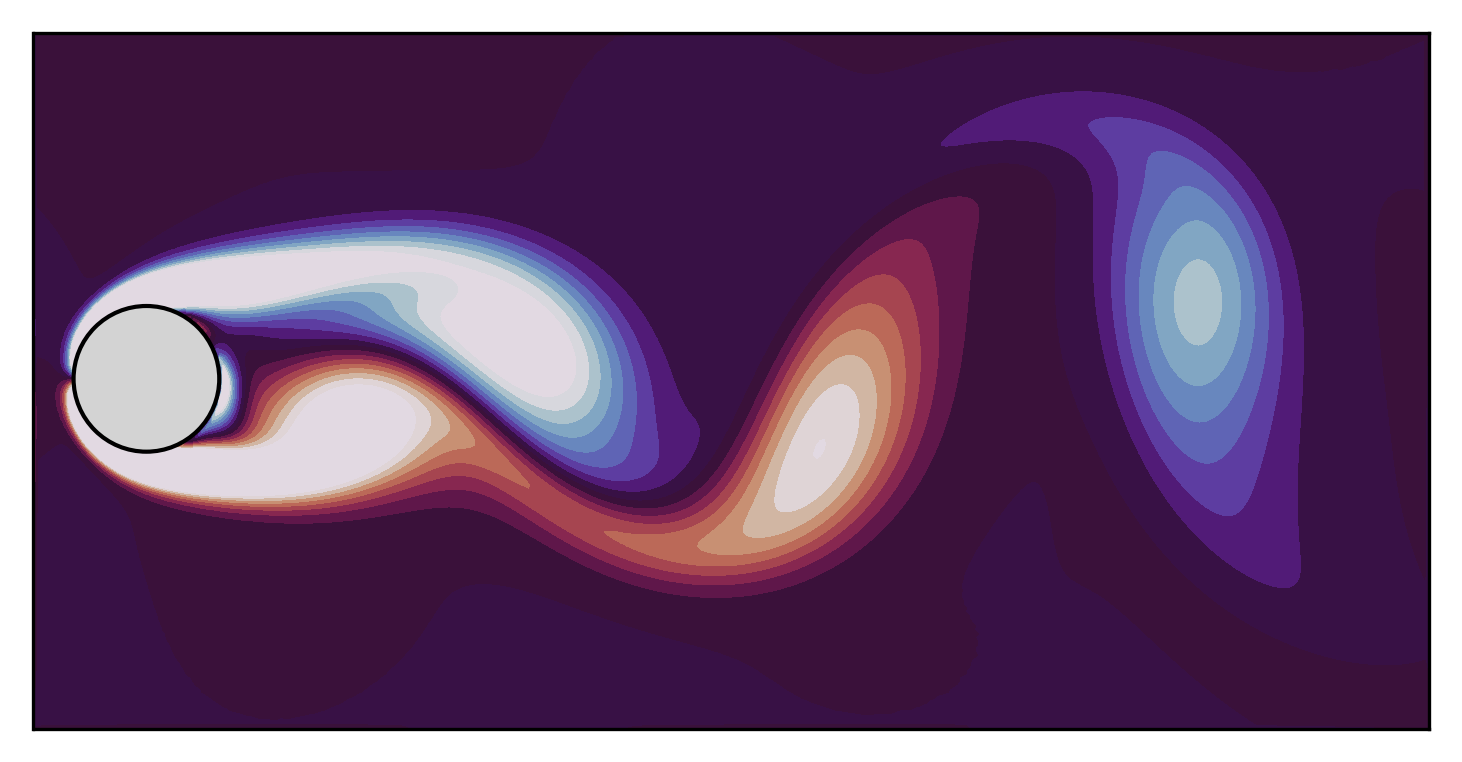

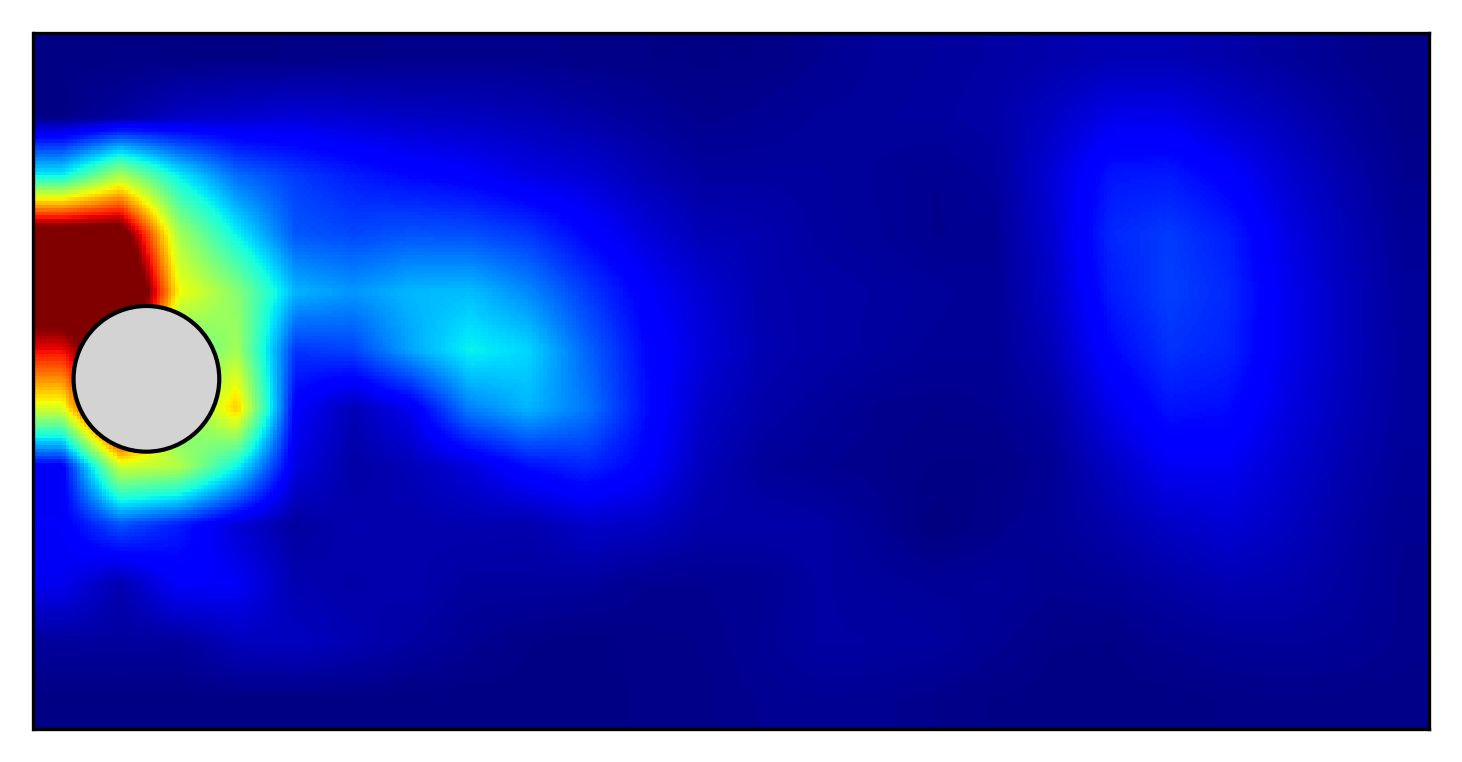

In [10]:
num = 0
Xm,Ym = np.meshgrid(xca,yca)

ax = plt.figure(dpi=300)
ax = plt.axes()
circ=patches.Circle(xy=(9,0),radius=0.5,fc="lightgray",ec="black") # prepare Circle
ax.add_patch(circ)
plt.contourf(Xm,Ym,omega[num,:,:,0].T,200,cmap='twilight',vmin=-2,vmax=2)
plt.gca().set_aspect('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.tick_params(color='white')
plt.show()


ax = plt.figure(dpi=300)
ax = plt.axes()
circ=patches.Circle(xy=(9,0),radius=0.5,fc="lightgray",ec="black") # prepare Circle
ax.add_patch(circ)
plt.pcolormesh(Xm,Ym,grad_cam_map[num,:,:].T,cmap='jet',vmin=0,vmax=0.02)
plt.gca().set_aspect('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.tick_params(color='white')
plt.show()